In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing the Libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import cv2
import warnings
from pathlib import Path
import pandas


## Extracting the Data

In [3]:
classes = os.listdir("/kaggle/input/brain-tumor-dataset/Brain_Tumor_Dataset")
classes

['Negative', 'Positive']

In [4]:
images_path = Path("/kaggle/input/brain-tumor-dataset/Brain_Tumor_Dataset")

for c in classes:
  print(f' {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

 Negative = 2000 images
 Positive = 3266 images


### Constants

In [5]:
IMAGE_SIZE = 128 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 10

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-tumor-dataset/Brain_Tumor_Dataset", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5266 files belonging to 2 classes.


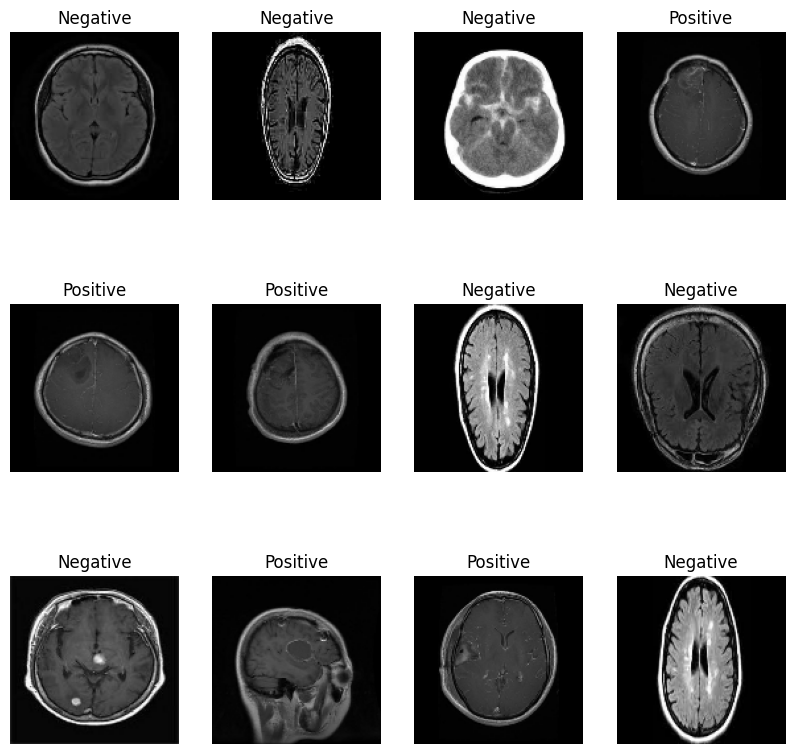

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

## Defining the Pre-processing and Data Augmentation Processes

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # test_size = int(test_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

132 16 17


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/(IMAGE_SIZE-1))
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

## Model

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4 #quantidade de classes
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
132/132 [==============================] - 80s 536ms/step - loss: 0.4350 - accuracy: 0.8108 - val_loss: 0.2544 - val_accuracy: 0.8956
Epoch 2/10
132/132 [==============================] - 67s 504ms/step - loss: 0.2259 - accuracy: 0.9205 - val_loss: 0.1875 - val_accuracy: 0.9357
Epoch 3/10
132/132 [==============================] - 67s 506ms/step - loss: 0.1786 - accuracy: 0.9311 - val_loss: 0.1673 - val_accuracy: 0.9398
Epoch 4/10
132/132 [==============================] - 67s 508ms/step - loss: 0.1508 - accuracy: 0.9444 - val_loss: 0.1050 - val_accuracy: 0.9578
Epoch 5/10
132/132 [==============================] - 67s 510ms/step - loss: 0.1418 - accuracy: 0.9496 - val_loss: 0.1636 - val_accuracy: 0.9378
Epoch 6/10
132/132 [==============================] - 67s 506ms/step - loss: 0.1228 - accuracy: 0.9531 - val_loss: 0.0939 - val_accuracy: 0.9659
Epoch 7/10
132/132 [==============================] - 67s 509ms/step - loss: 0.1086 - accuracy: 0.9576 - val_loss: 0.1217 - val_ac

In [18]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 7s 130ms/step - loss: 0.1132 - accuracy: 0.9540


Text(0.5, 1.0, 'Training and Validation Accuracy')

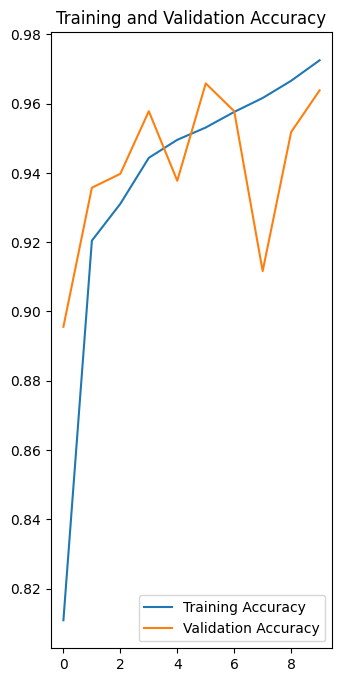

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array, verbose=0)

    predicted_class_number = np.argmax(predictions[0])
    predicted_class = classes[predicted_class_number]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence, predicted_class_number

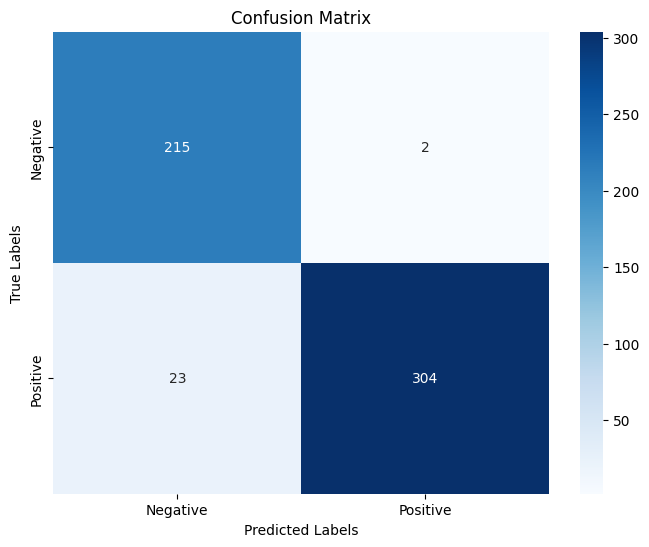

In [21]:
true_labels=[]
predicted_labels=[]
i=0
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _, predicted_class_number = predict(model, images[i].numpy())
        true_labels.append(labels[i].numpy())
        predicted_labels.append(predicted_class_number)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

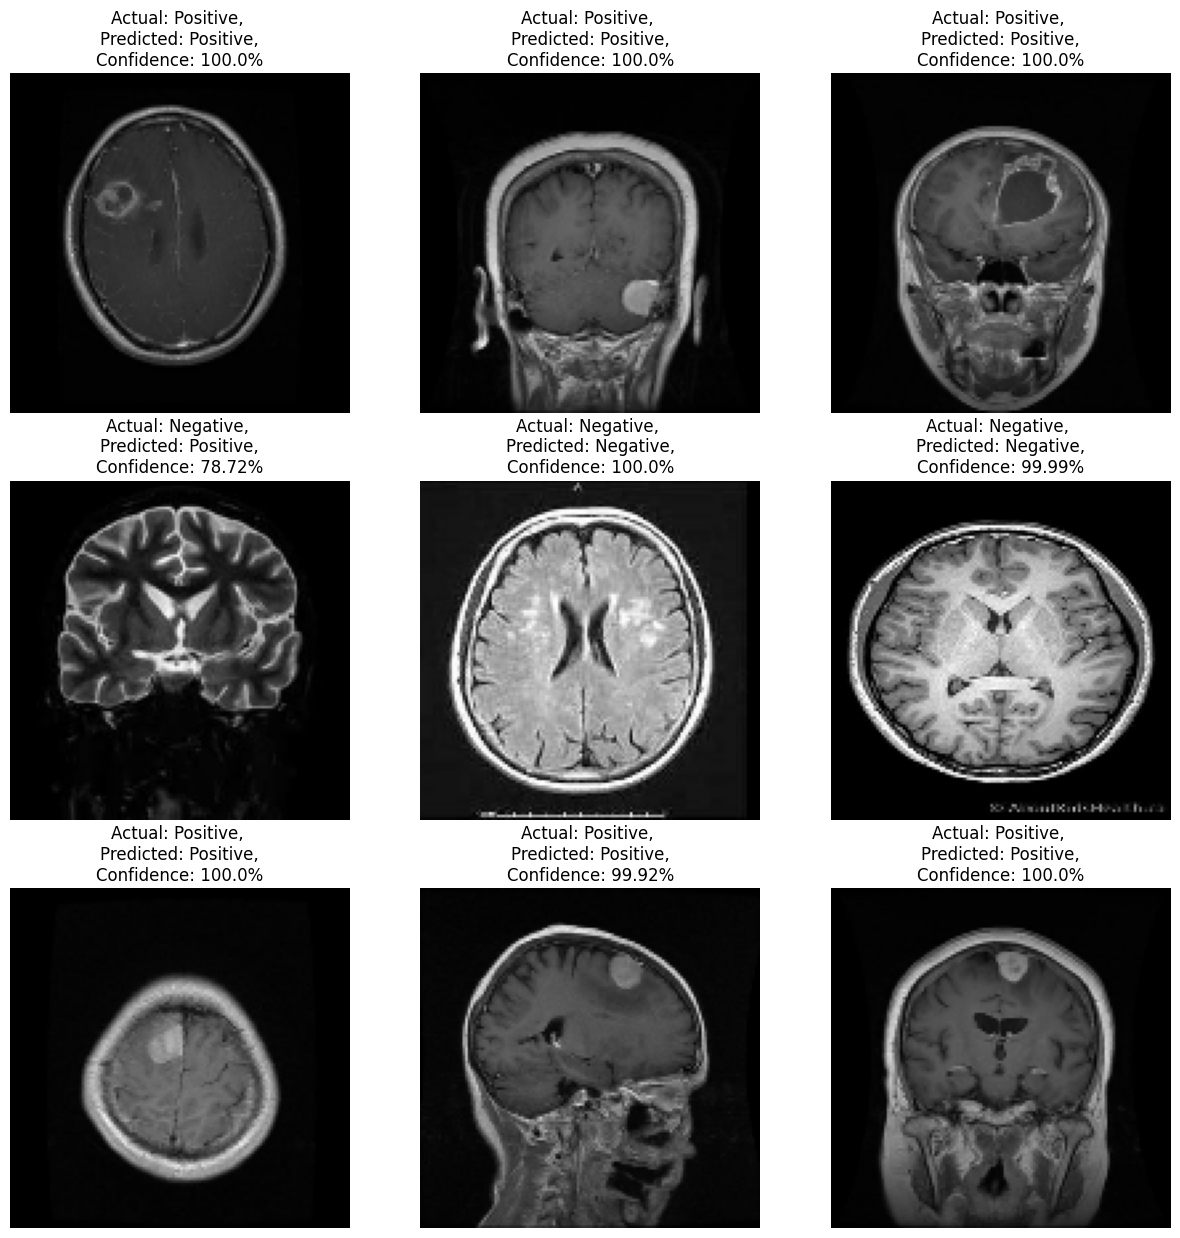

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, predicted_class_number = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
model.save("brainTumor-model")

In [24]:
model.save('brainTumor-model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
